In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as sc
from scipy import special;
plt.rcParams['text.usetex'] = True
import mpmath
import decimal

In [5]:
from numba import jit,vectorize,njit
from numba import njit, prange
import time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Geral matriz <n,m|$\frac{\gamma_b}{r}$|$n^{\prime}$,m>

In [4]:
#@jit
def matriz(n,m,g):
    matriz=np.empty((n,n))
    for i in prange(n):
        for j in prange(n):
            if (i==j):
                matriz[i][j]=(j+0.5)+g*anali(i,j,m)
            else:
                matriz[i][j]=g*anali(i,j,m)
    return matriz

Resultado analitico de cada elemento de matriz

In [48]:
def resul2(n,ni,m):
    soma=0
    for i in range(ni+1):
        for j in range(n+1):
            soma=soma+(-1)**(i+j)*math.gamma(abs(m)+i+0.5+j)/(math.factorial(i)*math.factorial(j)*math.factorial(ni-i)*math.factorial(n-j)*math.factorial(abs(m)+i)*math.factorial(abs(m)+j))
    #print(soma,np.sqrt(math.factorial(ni)*math.factorial(ni+abs(m))*(math.factorial(n)*math.factorial(n+abs(m))/2)))
    return soma*np.sqrt(math.factorial(ni)*math.factorial(ni+abs(m))*(math.factorial(n)*math.factorial(n+abs(m))/2))

In [40]:
#@njit
def resul4(n, ni, m):
    decimal.getcontext().prec = 50 # set a higher precision for the intermediate calculations
    fac2 = decimal.Decimal(str(mpmath.factorial(ni))) * decimal.Decimal(str(mpmath.factorial(n))) * decimal.Decimal(str(mpmath.sqrt(mpmath.factorial(ni) / mpmath.factorial(ni + abs(m)) * (mpmath.factorial(n) / mpmath.factorial(n + abs(m))))))
    soma = decimal.Decimal(0)

    for i in prange(0, (ni + 1 - abs(m))):
        for j in prange(0, (n + 1 - abs(m))):
            # evaluate the gamma function with high precision using mpmath
            gamma1 = mpmath.gamma(decimal.Decimal(abs(m)) + decimal.Decimal(i) + decimal.Decimal('0.5') + decimal.Decimal(j))

            # calculate the product of factorials without using math.factorial
            factorial_product = decimal.Decimal(1)
            for k in prange(i):
                factorial_product *= decimal.Decimal(k + 1)
            for k in prange(j):
                factorial_product *= decimal.Decimal(k + 1)
            for k in prange(ni - abs(m) - i):
                factorial_product *= decimal.Decimal(k + 1)
            for k in prange(n - abs(m) - j):
                factorial_product *= decimal.Decimal(k + 1)
            for k in prange(abs(m) + i):
                factorial_product *= decimal.Decimal(k + 1)
            for k in prange(abs(m) + j):
                factorial_product *= decimal.Decimal(k + 1)

            # add the term to the sum
            soma += (-1) ** (i + j) * gamma1 / factorial_product

    return soma * fac2


In [23]:
def resul3(n,ni,m):
    fac2=math.factorial(ni)*math.factorial(n)*np.sqrt(math.factorial(ni)/math.factorial(ni+abs(m))*(math.factorial(n)/math.factorial(n+abs(m))))
    soma=0
    for i in range(0,(ni+1-abs(m))):
        for j in range(0,(n+1-abs(m))):
            soma=soma+(-1)**(i+j)*math.gamma(abs(m)+i+0.5+j)/(math.factorial(i)*math.factorial(j)*math.factorial(ni-abs(m)-i)*math.factorial(n-abs(m)-j)*math.factorial(abs(m)+i)*math.factorial(abs(m)+j))
    return soma*fac2

In [55]:
#@njit(parallel=True)
def anali(n,ni,m):
    a=0
    for i in prange(ni+1):
        a+=(-1)**i*(math.gamma(i+abs(m)+0.5)*math.gamma(n-i+0.5))/(math.gamma(i+1.0)*math.gamma(ni-i+1.0)*math.gamma(i+abs(m)+1.0)*math.gamma(0.5-i))
    a=a*math.sqrt(math.gamma(ni+1.0)*math.gamma(ni+abs(m)+1.0)/(math.gamma(n+1.0)*2*math.gamma(n+abs(m)+1.0)))
    return a

In [109]:
@jit
def anali2(n, ni, m):
    a = 0
    for i in prange(ni+1):
        a += (-1)**i * (mpmath.gamma(i+abs(m)+0.5) * mpmath.gamma(n-i+0.5)) / (mpmath.gamma(i+1.0) * mpmath.gamma(ni-i+1.0) * mpmath.gamma(i+abs(m)+1.0) * mpmath.gamma(0.5-i))
    return  a * mpmath.sqrt(mpmath.gamma(ni+1.0) * mpmath.gamma(ni+abs(m)+1.0) / (mpmath.gamma(n+1.0) * 2*mpmath.gamma(n+abs(m)+1.0)))


In [114]:
start=time.time()
print(anali2(1000,1000,0))
print(-start+time.time())

0.0828594355114946
0.4197573661804199


In [100]:
#@njit(parallel=True)
def matriz2(n,m,g):
    matriz=np.empty((n,n))
    for i in prange(n):
        for j in prange(i,n):
            if i == j:
                a = g*anali2(j,i,m)+(i+0.5)
            else:
                a = g*anali2(j,i,m)
            matriz[j][i] = matriz[i][j] =  a
    return matriz


In [35]:
#@jit
def f(r,n,m):
    x=r*0.5*r
    return math.sqrt(math.factorial(n)/math.factorial(n+abs(m)))*(x)**(np.abs(m)*0.5)*np.exp(-x*0.5)*sc.special.assoc_laguerre(x, n, np.abs(m))

In [32]:
import mpmath
@np.vectorize
def f(r, n, m):
    x = r * 0.5 * r
    return (mpmath.sqrt(mpmath.factorial(n) / mpmath.factorial(n + abs(m))) * (x)**(np.abs(m)*0.5) * np.exp(-x*0.5) * mpmath.laguerre(n,abs(m), x))


In [37]:
#@jit
def anali1(n,ni,m):
    r=np.linspace(0,50,500)
    return np.trapz(f(r,n,m)*f(r,ni,m),r)

In [38]:
start=time.time()
print(matriz1(300,0,y_3(0)))
print(time.time()-start)
#start=time.time()
#print(matriz2(400,0,y_3(0)))
#print(time.time()-start)

[[2.03499006e+00 7.67495031e-01 5.75621273e-01 ... 5.02307454e-02
  5.01464657e-02 5.00626087e-02]
 [7.67495031e-01 2.65124255e+00 6.71558152e-01 ... 5.02730985e-02
  5.01886056e-02 5.01045372e-02]
 [5.75621273e-01 6.71558152e-01 3.48335301e+00 ... 5.03156128e-02
  5.02309053e-02 5.01466242e-02]
 ...
 [5.02307454e-02 5.02730985e-02 5.03156128e-02 ... 2.97666719e+02
  1.34668112e-01 1.23945183e-01]
 [5.01464657e-02 5.01886056e-02 5.02309053e-02 ... 1.34668112e-01
  2.98666493e+02 1.34496155e-01]
 [5.00626087e-02 5.01045372e-02 5.01466242e-02 ... 1.23945183e-01
  1.34496155e-01 2.99666268e+02]]
82.10553646087646


In [3]:
#@njit(parallel=True)
def matriz1(n,m,g):
    matriz=np.empty((n,n))
    for i in prange(n):
        for j in prange(i,n):
            matriz[i][j]=matriz[j][i]=g*anali1(j,i,m)
    for i in prange(n):
        matriz[i][i]+=(i+0.5)
    return matriz

In [6]:
@jit
def y_2(k):
    return np.sqrt((2*abs(k)+1))/2

In [7]:
@jit
def y_3(k):
    return np.sqrt((4*abs(k)+3)/2)

In [8]:
@jit
def y_4(k):
    return np.sqrt(5+5*abs(k)-np.sqrt(73+64*abs(k)*(2+abs(k)))*0.5)*0.5**0.5

Parte de comparação

In [13]:
#print(matriz1(20,1,0.5)-matriz(20,1,0.5))
print(matriz1(200,1,0.5))#-matriz(60,2,0.5))

[[8.13328534e-01 1.10778366e-01 6.78376176e-02 ... 8.94506983e-04
  8.90003474e-04 8.85545085e-04]
 [1.10778366e-01 1.77416247e+00 1.19921099e-01 ... 1.26743808e-03
  1.26104484e-03 1.25471577e-03]
 [6.78376176e-02 1.19921099e-01 2.74968368e+00 ... 1.55526393e-03
  1.54740377e-03 1.53962267e-03]
 ...
 [8.94506983e-04 1.26743808e-03 1.55526393e-03 ... 1.97564178e+02
  4.81414734e-02 4.27828753e-02]
 [8.90003474e-04 1.26104484e-03 1.54740377e-03 ... 4.81414734e-02
  1.98564056e+02 4.80607039e-02]
 [8.85545085e-04 1.25471577e-03 1.53962267e-03 ... 4.27828753e-02
  4.80607039e-02 1.99563936e+02]]


Fazer a integral

$\int_{0}^{\infty} \psi(r) r \psi(r)r dr$


numero quântico=0 (fundamental)

In [13]:
file=open('autovalores.txt','w')
l=5
m=0
gab=y_2(m)
print("valor de $\gamma_b$",round(gab,2))
ni=0
n=350#(n-1) é dimensão
w,v=np.linalg.eigh(np.array(matriz1(n,m,gab)))
for i in range(n):
    file.write(str(v[0][ni]/abs(v[0][ni])*v[i][ni])+'\n')
file.close()

valor de $\gamma_b$ 0.5


In [14]:
rea=open('autovalores.txt','r')
lines = rea.read().split()
#print(lines)

Distância esperada $<r>$

In [9]:
#função de onda
start = time.time()
l=50

ni=0
n=200#(n-1) é dimensão
mi=[0,-1,-2,-3]
space=np.linspace(0,l,1000)
for m in mi:
    final=[]
    g=np.linspace(0.1,7,10)
    resul=[]
    for j in g:
        resul=[]
        w,v=sc.linalg.eigh(np.array(matriz1(n,m,j)),driver='evr')
        for k in space:
            soma=0

            for i in prange(n):

                soma+=np.sqrt(math.factorial(i)*math.factorial(ni+abs(m))/(math.factorial(ni)*2**abs(m)*math.factorial(i+abs(m))))*v[0][0]/abs(v[0][0])*v[i][ni]*sc.special.assoc_laguerre(k*k*0.5, i, abs(m))

            resul.append((soma*(k*k*0.5)**(np.abs(m)*0.5)*np.exp(-k*k*0.25))**2*k**2)
        #gerando a função de onda
        a=np.trapz(resul,space)
        #print(a)
        final.append(a)

    plt.plot(g,final, label='$<r>$ m='+str(m)+' ')

plt.ylabel("$<r>$ ", 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})
plt.xlabel('$\gamma_b$', 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})
plt.title('Valor esperado da distância relativa', 
          fontdict={'family': 'serif', 
                    'color' : 'darkblue',
                    'weight': 'bold',
                    'size': 18})
plt.legend()
plt.tight_layout()
plt.savefig('myfigure_00.png', dpi=200)
plt.grid() 

plt.show()

KeyboardInterrupt: 

Valor máximo $r_{max}$

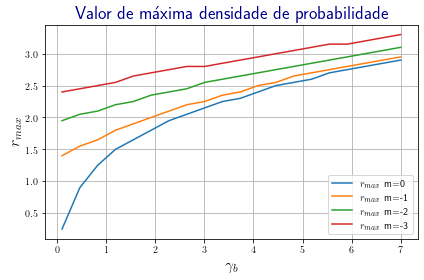

In [28]:
#função de onda
start = time.time()
l=50
vec=[]
#final=[]
mi=[0,-1,-2,-3]
ni=0
n=200#(n-1) é i
#rea=open('autovalores.txt','r')
#lines = rea.read().split()
space=np.linspace(0,l,1000)
g=np.linspace(0.1,7,20)
for m in mi:
    final=[]
    for j in g:
        resul=[]
        w,v=sc.linalg.eigh(np.array(matriz1(n,m,j)),driver='evr')
        #print(j)
        for k in space:
            soma=0

            for i in prange(n):

                soma+=np.sqrt(math.factorial(i)*math.factorial(ni+abs(m))/(math.factorial(ni)*2**abs(m)*math.factorial(i+abs(m))))*v[0][0]/abs(v[0][0])*v[i][ni]*sc.special.assoc_laguerre(k*k*0.5, i, abs(m))

            resul.append((soma*(k*k*0.5)**(np.abs(m)*0.5)*np.exp(-k*k*0.25))**2)
        #gerando a função de ondal
        h=l/1000
        #plt.plot(space,resul)
        for indi in prange(len(space)):
            der1=(resul[indi]-resul[indi+1])/h
            der2=(resul[indi+1]-resul[indi+2])/h
            if (der1*der2<0):
                #print(round(indi*h,3))
                final.append(round(indi*h,3))
                break
    plt.plot(g,final,label='$r_{max}$ m='+str(m))
plt.ylabel("$r_{max}$ ", 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})
plt.xlabel('$\gamma_b$', 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})
plt.title('Valor de máxima densidade de probabilidade', 
          fontdict={'family': 'serif', 
                    'color' : 'darkblue',
                    'weight': 'bold',
                    'size': 18})

plt.legend()
plt.tight_layout()
plt.savefig('myfigure_01.png', dpi=200)
plt.grid()

plt.show()


# plot dos coeficientes do fits
## primeiro fit
$f(r)=ar^2+br+c$



In [22]:
def func_1(x,c,b,a):
    return c*x**2+b*x+a

1.224744871391589
0.5 [-1.22471541  2.41964897 -0.17666441]
0.6811862178478972 [-1.50358693  3.39049565 -0.68788927]
0.8623724356957945 [-1.78249392  4.3747959  -1.21633277]
1.0435586535436916 [-2.05921523  5.36216097 -1.75353847]
1.224744871391589 [-2.33265718  6.34688463 -2.29463093]
a2= 0.14204798724830475 a1= 0.34794508774771815 a0= 0.14204798724830475
[[-1.22471541 -1.50358693 -1.78249392 -2.05921523 -2.33265718]
 [ 2.41964897  3.39049565  4.3747959   5.36216097  6.34688463]
 [-0.17666441 -0.68788927 -1.21633277 -1.75353847 -2.29463093]]


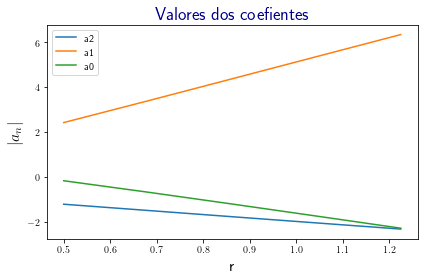

In [32]:
#função de onda
start = time.time()
l=5#tamanho do eixo x no grafico
vec=[]
m=0#degerencia
ni=1#energias
gab=y_3(m)
print(gab)
g=np.linspace(y_1(m),y_3(m),5)
n=200#(n-1) é dimensão
ac=[]
for i in range(m):
    vec.append([])

#gerador de pontos de energia
space=np.linspace(0,l,100)
#for i in g:
#gerando a função de onda
ind=0
for j in g:
    w,v=sc.linalg.eigh(np.array(matriz1(n,m,j)))

    resul=[]
    popt,pcov=[],[]
    for k in space:
        
        soma=0
        for i in range(n):
            
            soma+=np.sqrt(math.factorial(i)*math.factorial(ni+abs(m))/(2**abs(m)*math.factorial(ni)*math.factorial(i+abs(m))))*v[i][ni]*sc.special.assoc_laguerre(k*k*0.5,i,abs(m))
            
        resul.append(soma)

        
    #plt.plot(space,resul, label = "Numérico")
    popt,pcov= curve_fit(func_1,space,resul,maxfev=5000, method='trf')
    #plt.plot(space, func(space, *popt), 'r-', label='fit1' )
    ac.append(popt)
    print(j,popt)


#função quasi-exata

#coeficientes
#a0=(np.sqrt(2**(abs(m)-0.5)*sc.special.gamma(abs(m)*1.0+0.5)))**(-1)#1/np.linalg.norm(resul)#
r=np.linspace(0,100000,10000000)
#normalizando a0
rad=(r)**(2*abs(m))*np.exp(-r**2*0.5)*(1+(2*gab)*r/(2*abs(m)+1)+r*r/(2*abs(m)+1))**2*r

a0=(np.trapz(rad,r))**(-0.5)
a1=(2*gab)*a0/(2*abs(m)+1)
a2=a1/(2*gab)

print('a2=',a2,'a1=',a1,'a0=',a0)
#a2=a1/gab
#espaço
x=np.linspace(0,l,100)
act=np.transpose(ac)
print(act)
plt.plot(g[:],act[0],label='a2')
plt.plot(g[:],act[1],label='a1')
plt.plot(g[:],act[2],label='a0')
#plt.plot(g[2:],act[3][2:])
#plot
#plt.plot(x,(a2*x*x+a1*x+a0), label="Quasi-exact")
plt.ylabel("$|a_{n}|$", 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})
plt.xlabel('r', 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})

plt.legend()
plt.title('Valores dos coefientes', 
          fontdict={'family': 'serif', 
                    'color' : 'darkblue',
                    'weight': 'bold',
                    'size': 18})
plt.tight_layout()
plt.savefig('myfigure_03.png', dpi=200)
plt.show()
end = time.time()

#print(end-start)

## segundo fit 
$g(r)=ar^{b+1}+cr+d$

In [ ]:
def func(x,a,b,c,d):
    return a*x**(b+1)+c+d

funções que define $\gamma_{b}$

0.8660254037844386 [0.18968718 0.00715718 0.16814238 0.16814238]
0.9006737930810776 [0.19146944 0.02389086 0.16385742 0.16385742]
0.9353221823777167 [0.19297984 0.04072953 0.15973292 0.15973292]
0.9699705716743557 [0.19423342 0.05766854 0.15576212 0.15576212]
1.0046189609709948 [0.19524459 0.0747033  0.15193854 0.15193854]
1.0392673502676337 [0.19602717 0.09182937 0.148256   0.148256  ]
1.0739157395642729 [0.19659439 0.1090424  0.14470857 0.14470857]
1.1085641288609118 [0.19695891 0.12633817 0.14129058 0.14129058]
1.1432125181575508 [0.19713284 0.14371257 0.13799661 0.13799661]
1.17786090745419 [0.19712775 0.16116158 0.13482147 0.13482147]
1.212509296750829 [0.19695467 0.17868132 0.13176022 0.13176022]
1.247157686047468 [0.19662416 0.19626799 0.12880812 0.12880812]
1.281806075344107 [0.19614627 0.21391791 0.12596065 0.12596065]
1.3164544646407461 [0.19553058 0.2316275  0.12321347 0.12321347]
1.351102853937385 [0.19478624 0.24939328 0.12056247 0.12056247]
1.385751243234024 [0.19392194 0

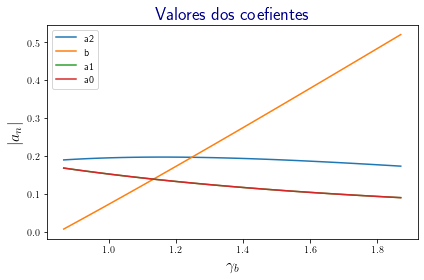

In [35]:
#função de onda
start = time.time()
l=5#tamanho do eixo x no grafico
vec=[]
m=-1#degerencicia
gab=y_3(m)
ni=0#energias
g=np.linspace(y_2(m),y_3(m),30)
n=200#(n-1) é dimensão
ac=[]

for i in range(m):
    vec.append([])
#adicionar os coeficientes

#gerador de pontos de energia
space=np.linspace(0,l,100)
#for i in g:
#gerando a função de onda
ind=0
for j in g:
    w,v=sc.linalg.eigh(np.array(matriz1(n,m,j)))

    resul=[]
    popt,pcov=[],[]
    for k in space:
        
        soma=0
        for i in range(n):
            
            soma+=np.sqrt(math.factorial(i)*math.factorial(ni+abs(m))/(2**abs(m)*math.factorial(ni)*math.factorial(i+abs(m))))*v[i][ni]*sc.special.assoc_laguerre(k*k*0.5,i,abs(m))
            
        resul.append(soma)

        
    #plt.plot(space,resul, label = "Numérico")
    popt,pcov= curve_fit(func,space,resul,maxfev=100000,method='dogbox')
    #plt.plot(space, func(space, *popt), 'r-', label='fit1' )
    #if (1.1<=popt[1]<=0.9):
    ac.append(popt)
    print(j,popt)

plt.ylabel("$R_{"+str(ni)+"}^{|"+str(abs(m))+"|}$($r$) ", 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})
#função quasi-exata

#coeficientes
#a0=(np.sqrt(2**(abs(m)-0.5)*sc.special.gamma(abs(m)*1.0+0.5)))**(-1)#1/np.linalg.norm(resul)#
r=np.linspace(0,100000,10000000)
#normalizando a0
rad=(r)**(2*abs(m))*np.exp(-r**2*0.5)*(1+(2*gab)*r/(2*abs(m)+1)+r*r/(2*abs(m)+1))**2*r

a0=(np.trapz(rad,r))**(-0.5)
a1=(2*gab)*a0/(2*abs(m)+1)
a2=a1/(2*gab)

print('a2=',a2,'a1=',a1,'a0=',a0)
#a2=a1/gab
#espaço
x=np.linspace(0,l,100)
#plot
#plt.plot(x,(a2*x*x+a1*x+a0), label="Quasi-exact")
#print(ac)
act=np.transpose(ac)
plt.plot(g[:],act[0][:],label='a2')
plt.plot(g[:],act[1][:],label='b')
plt.plot(g[:],act[2][:],label='a1')
plt.plot(g[:],act[3][:],label='a0')
plt.ylabel("$|a_{n}|$ ", 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})

plt.xlabel('$\gamma_b$', 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})

plt.title('Valores dos coefientes', 
          fontdict={'family': 'serif', 
                    'color' : 'darkblue',
                    'weight': 'bold',
                    'size': 18})

plt.legend()
plt.tight_layout()
plt.savefig('myfigure_02.png', dpi=200)
plt.show()
end = time.time()

#print(end-start)

## terceiro fit 
$g(r)=ar^{b}+cr+d$

In [35]:
def func(x,b,c,d):
    return b*x*x+c*x+d

a2= 0.04708322002449848 a1= 0.1761692779977675 a0= 0.14124966007349543


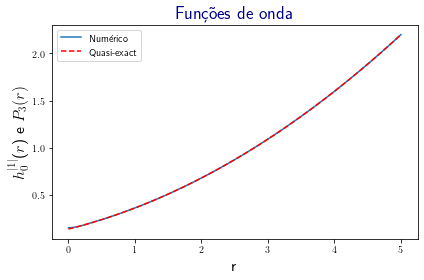

In [37]:
#função de onda
start = time.time()
l=5#tamanho do eixo x no grafico
vec=[]
m=-1#degerencicia
gab=y_3(m)
ni=0#energias
g=np.linspace(gab,gab,1)
n=200#(n-1) é dimensão
for i in range(m):
    vec.append([])

#gerador de pontos de energia
space=np.linspace(0,l,100)
#for i in g:
#gerando a função de onda
ind=0
for j in g:
    w,v=sc.linalg.eigh(np.array(matriz1(n,m,j)))

    resul=[]
    for k in space:
        
        soma=0
        for i in range(n):
            
            soma+=np.sqrt(math.factorial(i)*math.factorial(ni+abs(m))/(2**abs(m)*math.factorial(ni)*math.factorial(i+abs(m))))*v[i][ni]*sc.special.assoc_laguerre(k*k*0.5,i,abs(m))
            
        resul.append(soma)
        if i==0.0:
            print(soma)
        
        
    plt.plot(space,resul, label = "Numérico")


plt.ylabel("$h_{"+str(ni)+"}^{|"+str(abs(m))+"|}$($r$)  e $P_{{3}}(r)$", 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})
#função quasi-exata

#coeficientes
#a0=(np.sqrt(2**(abs(m)-0.5)*sc.special.gamma(abs(m)*1.0+0.5)))**(-1)#1/np.linalg.norm(resul)#
r=np.linspace(0,100000,10000000)
#normalizando a0
rad=(r)**(2*abs(m))*np.exp(-r**2*0.5)*(1+(2*gab)*r/(2*abs(m)+1)+r*r/(2*abs(m)+1))**2*r

a0=(np.trapz(rad,r))**(-0.5)
a1=(2*gab)*a0/(2*abs(m)+1)
a2=a1/(2*gab)

print('a2=',a2,'a1=',a1,'a0=',a0)
#a2=a1/gab
#espaço
x=np.linspace(0,l,100)
#plot
plt.plot(x,(a2*x*x+a1*x+a0), label="Quasi-exact",linestyle='--',color='red')
plt.xlabel('r', 
          fontdict={'family': 'serif', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})
plt.title('Funções de onda ', 
          fontdict={'family': 'serif', 
                    'color' : 'darkblue',
                    'weight': 'bold',
                    'size': 18})
plt.legend()

plt.tight_layout()

plt.show()
end = time.time()

#print(end-start)